In [1]:
import dddm

In [2]:
import wimprates as wr
wr.__version__

'0.3.2'

In [3]:
wr

<module 'wimprates' from '/home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates/__init__.py'>

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import numericalunits as nu

In [6]:
from tqdm import tqdm

In [7]:
from scipy.integrate import quad as scipy_int

In [8]:
import pandas as pd

In [9]:
import scipy

# Direct detection of Dark matter using different target materials #

Author:

Joran Angevaare <j.angevaare@nikef.nl>

Date:

14 october 2019 

## Goal ## 

- Roughly reproduce <https://journals.aps.org/prd/abstract/10.1103/PhysRevD.83.083505>
- Update the results thereof with more recent knowledge of the DM-distribution

### Approach ###
To achieve these goals, we must first get a decent recoil spectrum, that is flexible enough to have different astrophysical parameters. Further, it must also be flexible enough to be able to allow for different analytic functions to be added to the model. For instance, we must be able to incorporate the $\rm{SHM}^{++}$ as presented here <https://arxiv.org/abs/1810.11468>.

When we have a sufficiently flexible model, we want to add in the detector physics, we should therein incorporate at least the following parameters:
- target
  - material
  - cross-section
- threshold
- background
- cut efficiency  
- volume
- exposure

Finally we should perform the inference

## HALO model ##



/home/joran/miniconda3/envs/py3.10/lib/python3.10/site-packages/wimprates/halo.py:143: RuntimeWarning: divide by zero encountered in true_divide
  (v_esc**2 - v_earth_t**2 - v**2)


Text(0.5, 0, 'v [km/s]')

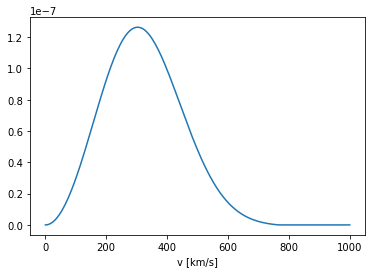

In [10]:
x = np.linspace(0,1000,200) * nu.km / nu.s
y2 = wr.observed_speed_dist(x, 0)
plt.plot(x/(nu.km / nu.s),y2)
# plt.axvline(310)
plt.xlabel("v [km/s]")
# plt.ylabel("$f (v)$")

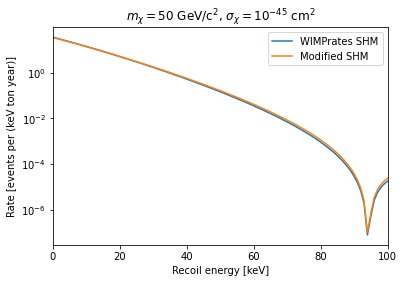

In [11]:
# NR's
energies = np.linspace(0.001, 100, 100)

# dr/dr
dr = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45)

plt.plot(energies, dr, label="WIMPrates SHM")

plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.title("$m_\chi = 50$ GeV/c${}^2$, $\sigma_\chi = 10^{-45}$ cm${}^2$")
plt.xlim(0, energies.max())

use_SHM = dddm.SHM()
dr_shm = wr.rate_wimp_std(energies, mw=50, sigma_nucleon=1e-45, halo_model = use_SHM)
plt.plot(energies, dr_shm, label = "Modified SHM")
plt.yscale('log')
plt.legend()

## Detector smearing

# Inference #
Below we setup the inference

In [12]:
# import emcee
# emcee.__version__

## Distribution of the DM ##
First we need to make a DM-rate spectrum

In [13]:
dddm.GenSpectrum??

In [14]:
experiments = {'Xe_simple': dddm.examples.XenonSimple,
               'Ge_simple': dddm.examples.GermaniumSimple,
               'Ar_simple': dddm.examples.ArgonSimple,
}
def get_gal_spec(det, mw =50):
    spec_class = dddm.GenSpectrum(
        dark_matter_model=use_SHM,
        experiment=experiments[det](n_energy_bins=200, e_min_kev=0, e_max_kev=200)
    )
    return spec_class.get_data(wimp_mass=mw, cross_section=1e-45, poisson = False)

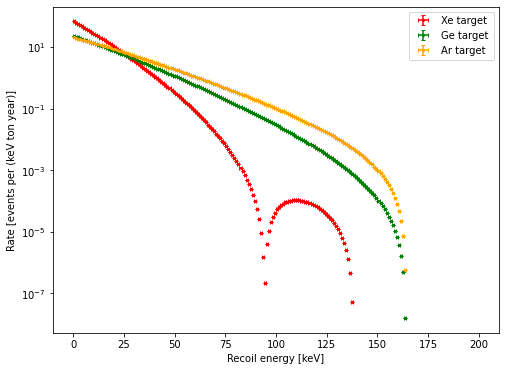

In [15]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_gal_spec('Xe_simple'), 'red', label = 'Xe target ', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ge_simple'), 'green', label = 'Ge target', plot_error = False)
dddm.plot_spectrum(get_gal_spec('Ar_simple'), 'orange', label = 'Ar target', plot_error = False)
plt.yscale("log")
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

In [16]:
def get_det_spec(det, mw =50):
    spec_class = dddm.DetectorSpectrum(
        dark_matter_model=use_SHM,
        experiment=experiments[det](n_energy_bins=200, e_min_kev=0, e_max_kev=200)
    )
    return spec_class.get_data(wimp_mass=mw, cross_section=1e-45, poisson = False)

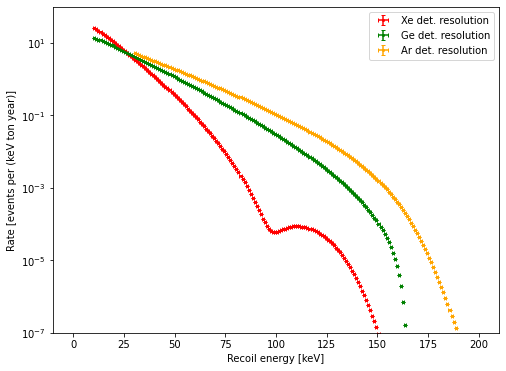

In [17]:
# plot_spectrum(xe_galact, label = 'un-smeared', linestyle = '--')
fig,ax=plt.subplots(figsize = (8,6))
dddm.plot_spectrum(get_det_spec('Xe_simple'), 'red', label = 'Xe det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ge_simple'), 'green', label = 'Ge det. resolution', plot_error = False)
dddm.plot_spectrum(get_det_spec('Ar_simple'), 'orange', label = 'Ar det. resolution', plot_error = False)
plt.yscale("log")
plt.ylim(1e-7,1e2)
plt.xlabel("Recoil energy [keV]")
plt.ylabel("Rate [events per (keV ton year)]")
plt.legend()

# Likelihood profiling

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.58it/s]


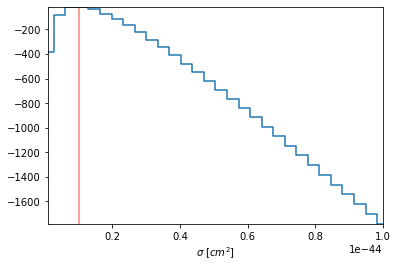

In [18]:
dddm.plt_ll_sigma_det()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.61it/s]


(-5000.0, 0.0)

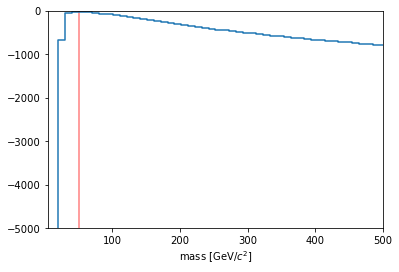

In [19]:
dddm.plt_ll_mass_spec()
plt.ylim(-5000,0)

# Nested sampling

In [20]:
context = dddm.base_context()
fit_class = context.get_sampler_for_detector(
    wimp_mass=50,
    cross_section=1e-45,
    sampler_name='nestle',
    detector_name='Xe_simple',
    prior="Pato_2010",
    halo_name='shm',
    detector_kwargs=None,
    halo_kwargs=None,
    sampler_kwargs=dict(nlive=100, tol=0.1, verbose=1),
    fit_parameters=('log_mass', 'log_cross_section',),
)
print(f"Fitting for parameters:\n{fit_class.config['fit_parameters']}")

2022-07-21 12:04:06.398160 | NestleSa |INFO     | __init__ (L85)       | initialized for Xe_simple detector.
2022-07-21 12:04:06.399722 | NestleSa |INFO     | set_fit_parameters (L121) | NestedSamplersetting fit parameters to ('log_mass', 'log_cross_section')
Fitting for parameters:
('log_mass', 'log_cross_section')


In [21]:
fit_class.run()
results = fit_class.get_summary()
print(results)

2022-07-21 12:04:06.425298 | NestleSa |INFO     | _fix_parameters (L167) | evaluate benchmark	all ready to go!
2022-07-21 12:04:06.428786 | NestleSa |INFO     | eval_benchmark (L179) | preparing for running, setting the benchmark
2022-07-21 12:04:06.462719 | NestleSa |WARNING  | _print_before_run (L135) | 
            --------------------------------------------------
            2022-07-21T12:04
	Final print of all of the set options:
            self.log = <Logger NestleSampler (INFO)>
            self.result = False
            self.benchmark_values = [0.00000000e+00 2.30477070e+02 8.26834953e+01 2.79654665e+01
 8.90966864e+00 2.42634489e+00 5.94391504e-01 1.19226142e-01
 1.63776790e-02 1.14944918e-03]
            self.config = immutabledict({'detector': 'Xe_simple', 'notes': 'default', 'start': '2022-07-21T12:04', 'prior': immutabledict({'log_mass': {'range': [0.1, 3], 'prior_type': 'flat', 'param': [0.1, 3], 'dist': <function flat_prior_distribution at 0x7f8038d88ee0>}, 'log_cross

2022-07-21 12:04:46.439626 | NestleSa |INFO     | check_did_save (L72) | did not save yet, we don't want to lose our results so better do it now
2022-07-21 12:04:46.441900 | NestleSa |INFO     | save_results (L112)  | Saving results after checking we did run
2022-07-21 12:04:46.444931 | NestleSa |INFO     | check_did_run (L69)  | did run
2022-07-21 12:04:46.448485 | dddm |INFO     | open_save_dir (L272) | open_save_dir::	using /home/joran/software/dddm/dddm/DD_DM_targets_data/nes_Nes2
2022-07-21 12:04:46.449033 | NestleSa |INFO     | get_save_dir (L254)  | get_save_dir	save_dir = /home/joran/software/dddm/dddm/DD_DM_targets_data/nes_Nes2
2022-07-21 12:04:46.450847 | NestleSa |INFO     | get_summary (L65)    | getting the summary (or at least trying) let's first see if I did run
2022-07-21 12:04:46.452055 | NestleSa |INFO     | check_did_run (L69)  | did run
2022-07-21 12:04:46.455187 | NestleSa |INFO     | get_summary (L99)    | 	, log_mass,  1.71 +/-  0.04
2022-07-21 12:04:46.457050 |

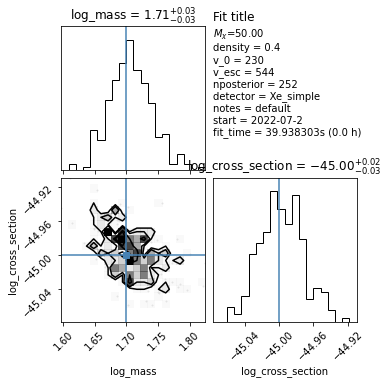

In [22]:
fit_class.show_corner()

In [23]:
fit_unconstrained = context.get_sampler_for_detector(
    wimp_mass=50,
    cross_section=1e-45,
    sampler_name='nestle',
    detector_name='Xe_simple',
    prior="Pato_2010",
    halo_name='shm',
    detector_kwargs=None,
    halo_kwargs=None,
    sampler_kwargs=dict(nlive=100, tol=0.1, verbose=1),
    fit_parameters=dddm.statistics.get_param_list(),
)

2022-07-21 12:04:47.835592 | NestleSa |INFO     | __init__ (L85)       | initialized for Xe_simple detector.
2022-07-21 12:04:47.840662 | NestleSa |INFO     | set_fit_parameters (L121) | NestedSamplersetting fit parameters to ['log_mass', 'log_cross_section', 'v_0', 'v_esc', 'density']


In [24]:
fit_unconstrained.run()
results = fit_unconstrained.get_summary()
print(results)

2022-07-21 12:04:47.872433 | NestleSa |INFO     | _fix_parameters (L167) | evaluate benchmark	all ready to go!
2022-07-21 12:04:47.874929 | NestleSa |INFO     | eval_benchmark (L179) | preparing for running, setting the benchmark
2022-07-21 12:04:47.910739 | NestleSa |WARNING  | _print_before_run (L135) | 
            --------------------------------------------------
            2022-07-21T12:04
	Final print of all of the set options:
            self.log = <Logger NestleSampler (INFO)>
            self.result = False
            self.benchmark_values = [0.00000000e+00 2.30477070e+02 8.26834953e+01 2.79654665e+01
 8.90966864e+00 2.42634489e+00 5.94391504e-01 1.19226142e-01
 1.63776790e-02 1.14944918e-03]
            self.config = immutabledict({'detector': 'Xe_simple', 'notes': 'default', 'start': '2022-07-21T12:04', 'prior': immutabledict({'log_mass': {'range': [0.1, 3], 'prior_type': 'flat', 'param': [0.1, 3], 'dist': <function flat_prior_distribution at 0x7f8038d88ee0>}, 'log_cross

2022-07-21 12:06:03.224087 | NestleSa |INFO     | check_did_save (L72) | did not save yet, we don't want to lose our results so better do it now
2022-07-21 12:06:03.226927 | NestleSa |INFO     | save_results (L112)  | Saving results after checking we did run
2022-07-21 12:06:03.229510 | NestleSa |INFO     | check_did_run (L69)  | did run
2022-07-21 12:06:03.232763 | dddm |INFO     | open_save_dir (L272) | open_save_dir::	using /home/joran/software/dddm/dddm/DD_DM_targets_data/nes_Nes3
2022-07-21 12:06:03.233334 | NestleSa |INFO     | get_save_dir (L254)  | get_save_dir	save_dir = /home/joran/software/dddm/dddm/DD_DM_targets_data/nes_Nes3
2022-07-21 12:06:03.234349 | NestleSa |INFO     | get_summary (L65)    | getting the summary (or at least trying) let's first see if I did run
2022-07-21 12:06:03.236979 | NestleSa |INFO     | check_did_run (L69)  | did run
2022-07-21 12:06:03.240902 | NestleSa |INFO     | get_summary (L99)    | 	, log_mass,  1.71 +/-  0.05
2022-07-21 12:06:03.242527 |

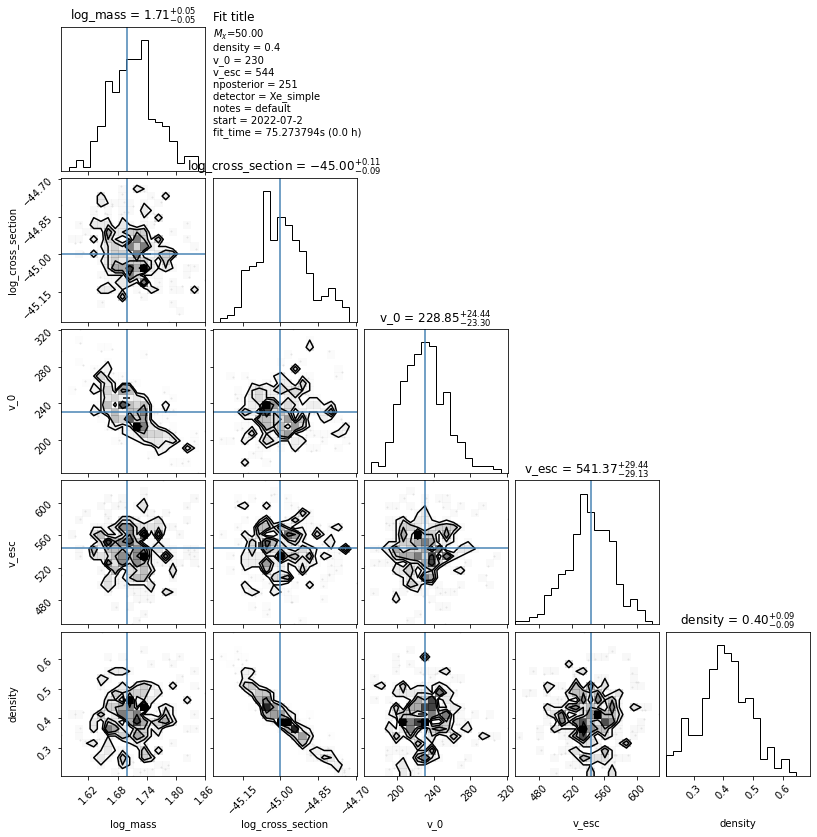

In [25]:
fit_unconstrained.show_corner()